# Dark Model

In [3]:
import pandas as pd
import cv2
import seaborn as sns
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline() 
from scipy.optimize import curve_fit
from scipy import stats
import numpy as np
import json
import matplotlib.pyplot as plt
import hdbscan
from datetime import datetime,time, tzinfo, timedelta
import pymysql
from matplotlib import cm
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator
from Dark import Dark_model
import matplotlib.patches as patches
import pygad
%load_ext autoreload
%autoreload 2

## Dark Model Class Implement

In [4]:
dark = Dark_model(delta=0.5,kernel_size=10)
tmp_choice = np.random.choice(dark.test_modes['id'].values, 1)[0]
mode_info = dark.test_modes.set_index('id').loc[tmp_choice,].to_frame().T
test_tmp = dark.template_bb[dark.template_bb['template']==tmp_choice].iloc[0]
# dark.draw_kernel(size=4)
# dark.draw_field(size=4)
# dark.test(plt_shrink=0.9)

In [5]:
dark.template_bb.T.drop('template')

,2022/04/16 01:27:45,2022/04/16 01:27:57,2022/04/16 01:28:09,2022/04/16 01:28:21,2022/04/16 01:28:33,2022/04/16 01:28:45,2022/04/16 01:28:57,2022/04/16 01:29:10,2022/04/16 01:29:22,2022/04/16 01:29:34,...,2022/04/17 01:01:44,2022/04/17 01:01:56,2022/04/17 01:02:08,2022/04/17 01:02:21,2022/04/17 01:02:33,2022/04/17 01:02:45,2022/04/17 01:02:57,2022/04/17 01:03:09,2022/04/17 01:03:21,2022/04/17 01:03:33
A1,0.0,0.0,0.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,...,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
A2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0
A3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0
A4,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0
B1,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,1.0,1.0
B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,3.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0
B3,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
B4,0.0,0.0,0.0,0.0,3.0,2.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,2.0
C1,1.0,1.0,1.0,3.0,2.0,0.0,2.0,1.0,1.0,1.0,...,0.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0
C2,0.0,0.0,0.0,2.0,2.0,3.0,2.0,3.0,1.0,3.0,...,3.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0


In [ ]:
%%time
for i in range(10):
    result = dark.bulb_conv(test_tmp)

CPU times: user 1.4 s, sys: 0 ns, total: 1.4 s
Wall time: 1.4 s


In [18]:
tt = dark.template_bb.T.drop('template')

In [28]:
%%time
for i in range(10):
    result = dark.fast_conv(test_tmp.drop('template').to_frame())

CPU times: user 195 ms, sys: 666 ms, total: 861 ms
Wall time: 18.9 ms


# Control Process

## Initial group

In [33]:
delta=0.25
kernel_size=10
init_st = pd.read_csv('initial_status.csv',index_col=0)

In [34]:
def random_status(illuminaire_num,pop_size=1):
    init_st = pd.read_csv('initial_status.csv',index_col=0)
    empt_init = init_st.copy().drop('BB1')
    index_choice = np.random.choice(empt_init.index, illuminaire_num%48,replace=False)
    empt_init.loc[index_choice,'status']=np.random.randint(2,4,illuminaire_num%48)
    # print(index_choice)
    if illuminaire_num>=48:
        empt_init['status']= empt_init['status']+ np.random.randint(2,4,48)
    empt_init.loc[empt_init['status']>3,'status']=1
    # print(empt_init.loc[index_choice])
    empt_init.loc['BB1','status'] = 1
    pop_arr = []
    if pop_size >1:
        arr = empt_init['status'].values
        for gg in range(pop_size):
            np.random.shuffle(arr)
            pop_arr.append(arr.tolist())
        pop_arr = np.array(pop_arr).T
        empt_init = pd.DataFrame(pop_arr,index=empt_init.index )
        empt_init.loc['BB1'] = 1
    return empt_init

In [35]:
st_dcit = {0:0,1:1,2:0.5,3:0.5}

In [36]:
random_status(63,pop_size=1)['status'].map(st_dcit).sum()-1

31.5

In [37]:
def group_initial(pop_size,illuminaire_num,num_diff = 10):    
    pop_list = [24]*int(pop_size/24) + [pop_size%24]
    ill_num = np.clip(np.linspace(-1,1,len(pop_list))*num_diff+illuminaire_num,0,95)
    # print(pop_list,ill_num)
    groups = []
    df = pd.DataFrame([])
    for nn,pp in zip(ill_num,pop_list):
        if df.empty:
            df = random_status(int(nn),pop_size=int(pp))
        else:
            df = pd.merge(df,random_status(int(nn),pop_size=int(pp)),left_index=True,right_index=True,how='left')
            df.columns = range(df.shape[1])
    return df

In [38]:
group_initial(pop_size = 100,illuminaire_num = 60,num_diff = 40)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A1,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
A2,2.0,0.0,3.0,1.0,2.0,0.0,0.0,3.0,0.0,0.0,...,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
A3,3.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
A4,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
B1,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,2.0,...,1.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,2.0,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B3,2.0,0.0,3.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B4,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,3.0,...,2.0,3.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0
C1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,...,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0
C2,3.0,0.0,2.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,...,2.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0


## Initial dark model

In [39]:
# daylight

In [40]:
# dark1,illuminaire_num = init_dark(daylight,target = 1250,delta=0.25,kernel_size=10)

In [41]:
# illuminaire_num

##  initial Daylight

## Fitness Function

In [42]:

def MSE(result): 
    return np.sum(result**2,axis=1)/result.shape[1]
def MAE(result): 
    return np.sum(abs(result),axis=1)/result.shape[1]
class Control:
    def __init__ (self,dark_model,daylight,method,target,pop_size,ill_num,num_diff):
        self.Loss_dict = {
                    'mse': MSE,
                    'mae': MAE,
                }
        self.st_dict = {0:0,1:1,2:0.5,3:0.5}
        self.method = method
        self.conv_arr = dark_model.conv_arr
        self.daylight = daylight['z'].values
        self.loss = self.Loss_dict[method]
        self.y_target = target
        self.pop_size = pop_size
        self.group = group_initial(pop_size,ill_num,num_diff).applymap(\
                                    lambda a: self.st_dict[a]).drop('BB1').values.T
        self.init = pd.read_csv('initial_status.csv',index_col=0)
    def fitness_func(self,solution, solution_idx):
        solution = np.append(solution, 1)
        y_ = solution.reshape(1,-1).dot(self.conv_arr) + self.daylight
        return - self.loss(y_-self.y_target)[0]  
    def init_dark(self,daylight,target,delta=0.25,kernel_size=10):
        all_on = init_st.copy()
        all_on['status']=1
        dark = Dark_model(delta=delta,kernel_size=kernel_size)#mn=[-1,-2],mx=[10,11]
        daylighting = pd.merge( dark.bulb_conv(all_on.squeeze()),daylight,  how='left', left_on=['x','y'], right_on = ['x','y'])
        daylighting['z'] = daylighting.apply(lambda x: x['z_x']+x['z_y'],axis=1)
        illuminaire_num = int(target/daylighting['z'].mean()*48*2)
        zone = daylighting[(daylighting['z']>target*1.1)&(daylighting['z']<target*1.3)]
        mn=[-1,-2]
        mx=[10,11]
        if not zone.empty:
            min_pos = zone.min()[['x','y']].values
            max_pos = zone.max()[['x','y']].values
            if (max_pos[1]-min_pos[1])*(max_pos[0]-min_pos[0]) > 64:
                print('Zone Change',min_pos,max_pos)
                mn=min_pos
                mx=max_pos
                fig = plt.figure()
                ax = fig.add_subplot(1,1,1)
                sns.scatterplot(data=zone,x='y',y='x',hue='z')
                rect = patches.Rectangle((min_pos[1],min_pos[0]),
                                 (max_pos[1]-min_pos[1]),
                                 (max_pos[0]-min_pos[0]),

                                 linewidth=2,
                                 edgecolor='black',
                                 # angle=90,
                                 fill = False)
                ax.add_patch(rect)
                # ax.add_patch(rect)
                ax.legend(loc='center')
                plt.ylim(12,-2)
                plt.xlim(-2,11)
                plt.show()
            else:
                print('Zone initial Failed')

        return Dark_model(delta=delta,kernel_size=kernel_size,mn=mn,mx=mx,filter_size = 5),illuminaire_num

In [77]:
dark = Dark_model(delta=0.25,kernel_size=10)
daylight = dark.BB1_df[['x','y']].copy()
daylight['z']=200
cc = Control(dark,daylight,'mse',target=1250,pop_size=300,ill_num=50,num_diff=30)

Zone Change [-1.  -1.5] [10.  10.5]


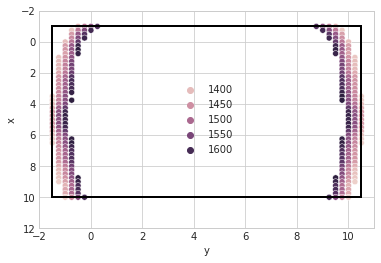

In [78]:
dark_test,num = cc.init_dark(daylight,target=1250,delta=0.25,kernel_size=10)

In [79]:
dark_test.conv_arr.shape

(49, 2205)

In [80]:
cc.conv_arr.shape

(49, 2385)

In [81]:
def fitness_func(solution, solution_idx):
    return cc.fitness_func(solution, solution_idx) 
# dark1.fast_conv(group_initial)

In [82]:

# cost = dark1.lux_diff(lighting,compare_status)

## GA

In [67]:
last_fitness = 0
def on_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]



In [100]:
%%time
%matplotlib inline
# Creating an instance of the GA class inside the ga module. Some parameters are initialized within the constructor.
ga_instance = pygad.GA(num_generations=500,
                       fitness_func=fitness_func,
                       num_parents_mating=int(cc.pop_size/3),
                       sol_per_pop=cc.pop_size,
                       # initial_population = cc.group,
                       gene_space = [0,0.5,1],
                       num_genes=48,
                       # on_generation=on_generation,
#                        save_solutions=True,
#                        K_tournament=3,
                       # parent_selection_type='tournament',
                       mutation_type='Adaptive',
                       save_best_solutions=True,
                       mutation_num_genes = (3, 1),
                      )

# Running the GA to optimize the parameters of the function.
ga_instance.run()

/home/ianchen5273/.local/lib/python3.8/site-packages/pygad/pygad.py:787: UserWarning:

Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.



CPU times: user 12min 53s, sys: 1h 3min 20s, total: 1h 16min 14s
Wall time: 2min 3s


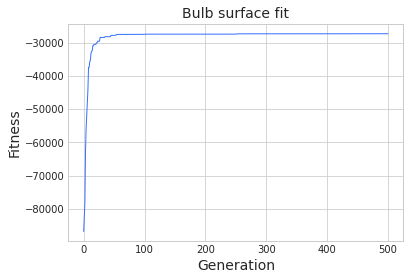

RMSE = 165.4060093810072


In [69]:
%matplotlib inline
ga_instance.plot_fitness(title="Bulb surface fit", linewidth=1)
plt.show()
solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)
# solution = np.append(solution, 1)
print("RMSE = {solution_fitness}".format(solution_fitness=abs(solution_fitness)**0.5))

In [70]:
solution.shape

(48,)

In [71]:
%matplotlib widget
def plot_resullt(solution):
    init_st['status'] = solution
    st_ = {0.5:2,1:1,0:0}
    init_st = init_st.applymap(lambda a: st_[a])
    dark = Dark_model(delta=0.25,kernel_size=10)
    dark.plot_ligting(init_st.squeeze(),pd.DataFrame({'z': (dark.bulb_conv(init_st.squeeze())['z'] + 200)}),shrink=1,target_lux=yt,slicing=4)
    

In [72]:
solution,solution.shape

(array([1. , 1. , 1. , 1. , 0.5, 0.5, 0.5, 1. , 1. , 0.5, 0. , 1. , 1. ,
        1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5, 0. , 0. , 0.5, 0. ,
        0.5, 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 0. , 1. ,
        1. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. ]),
 (48,))

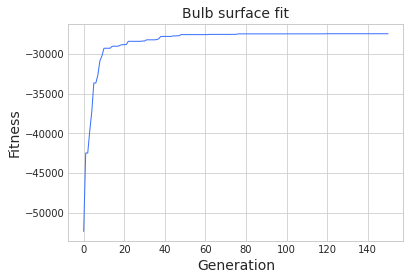

Parameters of the best solution : [1.  1.  1.  1.  1.  0.  0.5 1.  1.  0.5 0.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  0.5 0.5 0.  0.5 0.5 0.  0.5 0.5 1.  1.  1.  1.  1.  1.  1.  1.
 0.5 1.  1.  0.5 0.5 1.  1.  0.  1.  1.  1.  1.  1. ]
Fitness value of the best solution = -27461.83198238229
Index of the best solution : 0


In [73]:
%matplotlib inline
st_ = {0.5:2,1:1,0:0}
st_dict = {2:0.5,3:0.5,1:1,0:0}
ga_instance = pygad.GA(num_generations=150,
                       fitness_func=fitness_func,
                       num_parents_mating=100,
                       sol_per_pop=cc.pop_size,
                       gene_space = [0,0.5,1],
                       # crossover_type="single_point",
                       num_genes=48,
                       initial_population = random_status(int((sum(solution)-1)*2),cc.pop_size).applymap(lambda a: st_dict[a]).drop('BB1').values.T,
                       # on_generation=on_generation,
#                        save_solutions=True,
#                        K_tournament=3,
#                        parent_selection_type='tournament',
                       mutation_type='Adaptive',
                       save_best_solutions=True,
#                        allow_duplicate_genes=False,
                       suppress_warnings=True,
                       mutation_num_genes = (3, 1),
                      )
ga_instance.run()
ga_instance.plot_fitness(title="Bulb surface fit", linewidth=1)
plt.show()
solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)
solution = np.append(solution, 1)
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))


In [83]:
print("RMSE = {solution_fitness}".format(solution_fitness=abs(solution_fitness)**0.5))

RMSE = 165.716118655918


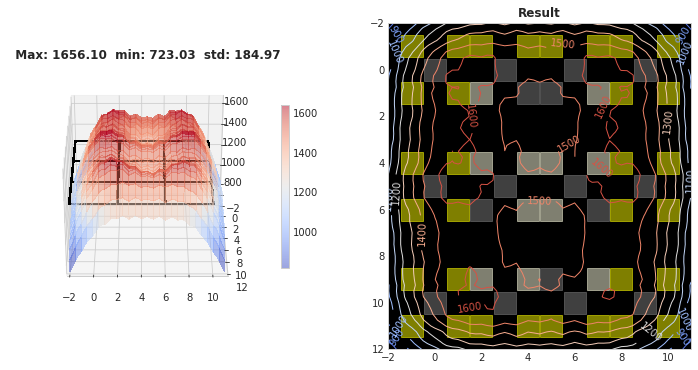

In [84]:
init_st['status'] = solution

init_st = init_st.applymap(lambda a: st_[a])
dark2 = Dark_model(delta=0.25,kernel_size=10,mn=[-2,-2],mx=[12,11])
dark2.plot_ligting(init_st.squeeze(),
                  pd.DataFrame({'z': (dark2.fast_conv(init_st) + 200).flatten()}),
                  shrink=0.8,target_lux=cc.y_target, slicing=16)

In [85]:
init_st['status'] = np.append(res_x.value/2,1)
init_st = init_st.applymap(lambda a: st_[a])
# dark2 = Dark_model(delta=0.5,kernel_size=10,mn=[-2,-2],mx=[12,11])
dark2 = Dark_model(delta=0.5,kernel_size=10,mn=[-2,-2],mx=[12,11])
dark2.plot_ligting(init_st.squeeze(),
                  pd.DataFrame({'z': (dark2.fast_conv(init_st) + 200).flatten()}),
                  shrink=0.8,target_lux=cc.y_target, slicing=16)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

## Linear programming

In [86]:
A,b = cc.conv_arr.T[:,:-1], cc.y_target-daylight['z'].values- cc.conv_arr.T[:,-1]

In [87]:
np.mean((cc.y_target-cc.daylight-cc.conv_arr.T.dot(solution))**2)**0.5

260.7831664525953

In [88]:
A1 = A/2

In [101]:
from scipy.optimize import lsq_linear
# [int(x*2)/2*np.sign(x) for x in res1.tolist()]

res = lsq_linear(A, b, bounds=(0, 1), 
                 # lsmr_tol='auto',
                 lsmr_tol='exact',
                 verbose=0)

In [90]:
np.mean((cc.y_target-cc.daylight-cc.conv_arr.T.dot(np.append(res.x,1)))**2)**0.5

99.23749310070238

In [92]:
cont_res = [float('{:.2f}'.format(x)) for x in (res.x).tolist()]
cont_res

[1.0,
 1.0,
 1.0,
 1.0,
 0.7,
 0.36,
 0.0,
 0.33,
 0.36,
 0.0,
 0.35,
 0.67,
 1.0,
 1.0,
 1.0,
 1.0,
 0.74,
 0.79,
 1.0,
 1.0,
 0.52,
 0.4,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4,
 0.52,
 1.0,
 1.0,
 0.79,
 0.74,
 1.0,
 1.0,
 1.0,
 1.0,
 0.59,
 0.6,
 0.35,
 0.0,
 0.0,
 0.36,
 0.59,
 0.58,
 1.0,
 1.0,
 1.0,
 1.0]

In [93]:
A1.shape,b.shape

((2385, 48), (2385,))

In [94]:
import cvxpy as cp
import numpy as np
# Generate a random problem
res_x = cp.Variable(48, integer=True)
constraints = [0<= res_x, res_x <= 2]
objective = cp.Minimize(cp.sum_squares(A1 @ res_x - b))
try:
    prob = cp.Problem(objective,constraints)
    prob.solve(solver='GUROBI')# mosek GUROBI GLOP CPLEX GLPK_MI SCIP XPRESS ,verbose=True
except:
    print("Status: ", prob.status)
print("The optimal value is", prob.value)
print("The norm of the residual is ", cp.norm(A1 @ x - b, p=2).value)
print("A solution x is")
print(res_x.value/2)

Academic license - for non-commercial use only - registered to ian930006@gmail.com
The optimal value is 24010556.335588768


ValueError: Incompatible dimensions (2385, 48) (2, 1)

In [126]:
np.mean((cc.y_target-cc.daylight-cc.conv_arr.T.dot(np.append(res_x.value/2,1)))**2)**0.5

100.33603150551757

# solver test

In [95]:
import cvxpy as cp
x = cp.Variable(2)
obj = cp.Minimize(x[0] + cp.norm(x, 1))
constraints = [x >= 2]
prob = cp.Problem(obj, constraints)
api_key = '30f852a3-f5bb-42e5-a6ec-868f97792f31'
# Solve with OSQP.
prob.solve(solver=cp.OSQP)
print("optimal value with OSQP:", prob.value)

# Solve with ECOS.
prob.solve(solver=cp.ECOS)
print("optimal value with ECOS:", prob.value)

# Solve with CVXOPT.
prob.solve(solver=cp.CVXOPT)
print("optimal value with CVXOPT:", prob.value)

# Solve with SCS.
prob.solve(solver=cp.SCS)
print("optimal value with SCS:", prob.value)

# Solve with SciPy/HiGHS.
prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
print("optimal value with SciPy/HiGHS:", prob.value)

# Solve with GLOP.
prob.solve(solver=cp.GLOP)
print("optimal value with GLOP:", prob.value)

# Solve with GLPK.
prob.solve(solver=cp.GLPK)
print("optimal value with GLPK:", prob.value)

# Solve with GLPK_MI.
prob.solve(solver=cp.GLPK_MI)
print("optimal value with GLPK_MI:", prob.value)

# Solve with GUROBI.
prob.solve(solver=cp.GUROBI)
print("optimal value with GUROBI:", prob.value)

# Solve with MOSEK.
# prob.solve(solver=cp.MOSEK)
# print("optimal value with MOSEK:", prob.value)

# Solve with CBC.
prob.solve(solver=cp.CBC)
print("optimal value with CBC:", prob.value)

# Solve with CPLEX.
# prob.solve(solver=cp.CPLEX)
# print("optimal value with CPLEX:", prob.value)

# Solve with NAG.
# prob.solve(solver=cp.NAG)
# print("optimal value with NAG:", prob.value)

# Solve with PDLP.
prob.solve(solver=cp.PDLP)
print("optimal value with PDLP:", prob.value)

# Solve with SCIP.
prob.solve(solver=cp.SCIP)
print("optimal value with SCIP:", prob.value)

# Solve with XPRESS.
# prob.solve(solver=cp.XPRESS)
# print("optimal value with XPRESS:", prob.value)

optimal value with OSQP: 6.0
optimal value with ECOS: 5.999999996660147
optimal value with CVXOPT: 5.999999999724494
optimal value with SCS: 5.999994970308411
optimal value with SciPy/HiGHS: 6.0
optimal value with GLOP: 6.0
optimal value with GLPK: 6.0
optimal value with GLPK_MI: 6.0
Academic license - for non-commercial use only - registered to ian930006@gmail.com
optimal value with GUROBI: 6.0
optimal value with CBC: 6.0
optimal value with PDLP: 6.0
optimal value with SCIP: 6.0


In [96]:
lighting = (dark.fast_conv(init_st)+ 200).reshape(dark.new_X.shape)
lighting = cv2.GaussianBlur(lighting, (9,9),0)

Gx= np.gradient(lighting,axis=1)

init_st['status'] = solution
grad_st = pd.merge(
    pd.merge(init_st[init_st['status']==0.5],dark.pos_df.astype('float'),how='left',left_index=True,right_index=True).reset_index(),
    pd.DataFrame({'x':dark.new_X.flatten(), 'y':dark.new_Y.flatten(),'grad':Gx.flatten()}),
    on=('x','y'),how='left')

init_st.loc[grad_st[grad_st['grad']>0]['index'],'status'] = 2
init_st.loc[grad_st[grad_st['grad']<0]['index'],'status'] = 3

In [97]:
init_st

,status
A1,1.0
A2,1.0
A3,1.0
A4,1.0
B1,1.0
B2,0.0
B3,3.0
B4,1.0
C1,1.0
C2,3.0


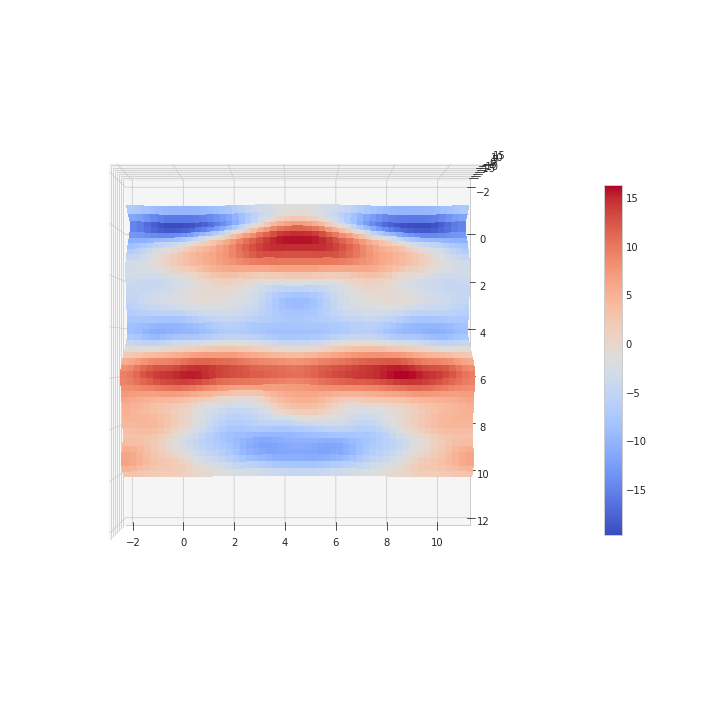

In [99]:
%matplotlib widget
# lighting = (solution.reshape(1,-1).dot(conv_arr) + 200).reshape(dark.new_X.shape)
# lighting = cv2.GaussianBlur(lighting, (9,9),0)

# Gx= np.gradient(lighting,axis=1)
# G = (Gx**2)**.5  # gradient magnitude
# N = G/G.max()  # normalize 0..1
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(
    dark.new_Y, dark.new_X, -Gx, rstride=1, cstride=1,
    # facecolors=cm.jet(N),
    cmap = cm.coolwarm,
    linewidth=0, antialiased=False, shade=False)
fig.colorbar(surf,shrink=0.5)
plt.ylim(12,-2)
plt.xlim(-2,11)
ax.view_init(elev=90, azim=-90)
        # plt.ylim(self.mx[0]
plt.tight_layout()
plt.show()